# 1. Import

In [157]:
from basic_functions import data_load
import pandas as pd
import numpy as np

In [158]:
#Load Datasets
X_train = data_load("data/X_train.csv")
y_train = data_load("data/y_train_clustered.csv")

Data loaded!
Data loaded!


# 2. CategoricalNB

## 2.1 Initial model Pipeline

In [159]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import CategoricalNB
from sklearn.impute import SimpleImputer


pipe_catnb = Pipeline(steps=[
    ("oe", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)),
    ("imputer", SimpleImputer(strategy = "most_frequent")),
    ("nb", CategoricalNB())
])

### 2.1.1 Gridsearch & Cross Validate Function

In [160]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, f1_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "f1_macro": make_scorer(f1_score, average="macro"),
    "neg_log_loss": "neg_log_loss"
}

def run_gridsearch(pipe, param_grid, X, y, name):
    gs = GridSearchCV(
        pipe,
        param_grid=param_grid,
        scoring="f1_macro",
        cv=cv,
        n_jobs=-1,
        refit=True
    )

    gs.fit(X, y)
    print(f"{name} best params: {gs.best_params_} | best f1: {gs.best_score_:.4f}")
    return gs


In [161]:
from sklearn.model_selection import cross_validate

def calculate_cv(pipeline, X, y, cv, scoring, show_results = True):

    cv_results   = cross_validate(pipeline, X.astype("category"), y, cv=cv, scoring=scoring)
    
    if show_results:
        for metric in scoring.keys():
            mean = cv_results[f"test_{metric}"].mean()
            std = cv_results[f"test_{metric}"].std()
            print(f"{metric}: {mean:.4f} ± {std:.4f}")

    return cv_results

In [162]:
param_grid = {
    "nb__alpha": [1e-3, 1e-2, 0.05, 0.1, 0.3, 1.0, 3.0, 10.0]
}
gs_catnb = run_gridsearch(pipe=pipe_catnb, param_grid=param_grid, X= X_train, y=y_train["income"], name="CatNB")

CatNB best params: {'nb__alpha': 0.001} | best f1: 0.4956


In [163]:
_ = calculate_cv(gs_catnb.best_estimator_, X_train, y_train["income"], cv, scoring)

accuracy: 0.5151 ± 0.0051
f1_macro: 0.4956 ± 0.0092
neg_log_loss: -1.2709 ± 0.0154


--> still bad results.

## 2.2 Problem visualization

### 2.2.1 Dataframe for analysis

In [164]:
clf = CategoricalNB(alpha=0.001)
clf.fit(X_train, y_train)
X_test = data_load("data/X_test.csv")
y_test = data_load("data/y_test_clustered.csv")

Data loaded!
Data loaded!


c:\Users\timmn\OneDrive\Dokumente\GitHub\Probabilistic-Machine-Learning_lecture-PROJECTS\projects\13-3NTXXXX_microcensus_income\venv\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [165]:
import numpy as np
probs = clf.predict_proba(X_test)
class_labels = clf.classes_

bestfit = np.argmax(probs, axis=1)
probs_masked = probs.copy()
probs_masked[np.arange(len(probs)), bestfit] = -1
secbestfit = np.argmax(probs_masked, axis=1)

top1_labels = class_labels[bestfit]
top2_labels = class_labels[secbestfit]

# max probability for each sample
max_probs = np.max(probs, axis = 1)
print(max_probs)

[0.45451871 0.6126356  0.76034415 ... 0.7206814  0.53930858 0.56738689]


In [166]:
# entropy for each sample
from scipy.stats import entropy
entropies = entropy(probs, axis=1)

In [167]:
y_test = y_test.reset_index(drop=True)

confusion_pairs = pd.DataFrame({
    "true_label": y_test["income"].values,
    "predicted_top1": top1_labels,
    "predicted_top2": top2_labels,
    "max_probability": max_probs,
    "entropy": entropies
})
confusion_pairs["is_correct"] = confusion_pairs["true_label"] == confusion_pairs["predicted_top1"]

### 2.2.2 Confusion and misclassification

In [168]:

pair_counts = (
    confusion_pairs
    .groupby(["predicted_top1", "predicted_top2"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

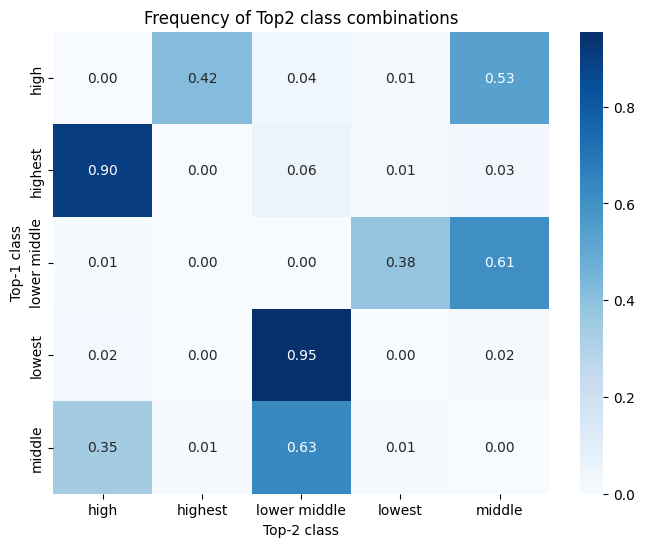

In [169]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = pair_counts.pivot(index="predicted_top1", columns="predicted_top2", values="count").fillna(0)
pivot_relative = pivot.div(pivot.sum(axis=1), axis=0)
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_relative, annot=True, fmt=".2f", cmap="Blues")
plt.title("Frequency of Top2 class combinations")
plt.xlabel("Top-2 class")
plt.ylabel("Top-1 class")
plt.show()


### 2.2.3 Misclassification

In [170]:
errors_df = confusion_pairs[confusion_pairs["true_label"] != confusion_pairs["predicted_top1"]]
conf_matrix_errors = (
    errors_df
    .groupby(["true_label", "predicted_top1"])
    .size()
    .unstack(fill_value=0)
)

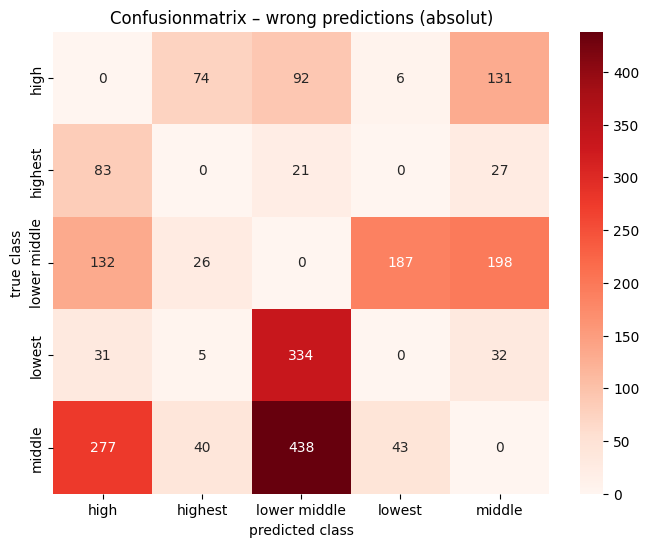

In [171]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_errors, annot=True, fmt=".0f", cmap="Reds")
plt.title("Confusionmatrix – wrong predictions (absolut)")
plt.xlabel("predicted class")
plt.ylabel("true class")
plt.show()

### 2.2.4 Connection between max(p) and entropy

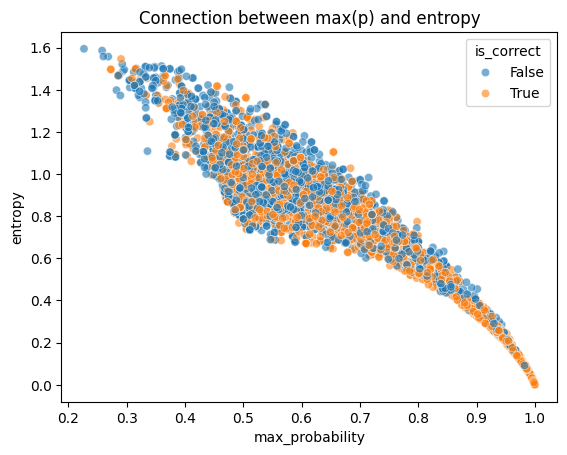

In [172]:
sns.scatterplot(data=confusion_pairs, x="max_probability", y="entropy", hue="is_correct", alpha=0.6)
plt.title("Connection between max(p) and entropy")
plt.show()

In [173]:
mask_high_conf = ((confusion_pairs["entropy"]< 0.7) & (confusion_pairs["max_probability"] > 0.5))

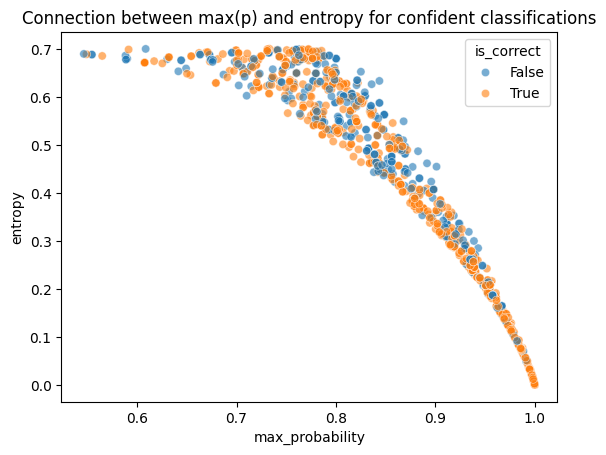

In [174]:
sns.scatterplot(data=confusion_pairs[mask_high_conf], x="max_probability", y="entropy", hue="is_correct", alpha=0.6)
plt.title("Connection between max(p) and entropy for confident classifications")
plt.show()

In [175]:
conf_and_correct = confusion_pairs[mask_high_conf]["is_correct"].mean()
print(f"Accuracy for conf. predictions: {conf_and_correct:.2%}")

Accuracy for conf. predictions: 66.57%


### 2.2.5 Uncertainty Max Probability

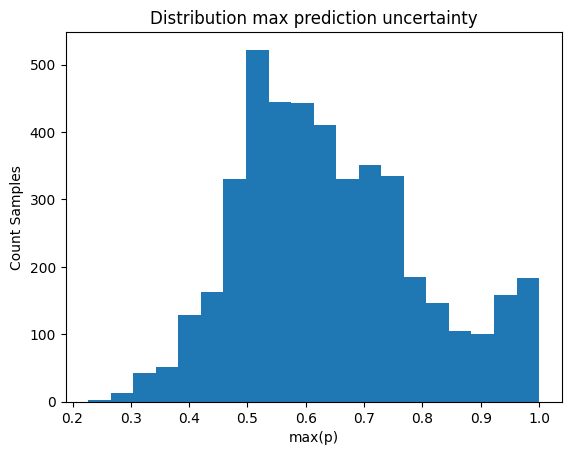

In [176]:
plt.hist(confusion_pairs["max_probability"], bins= 20)
plt.title("Distribution max prediction uncertainty")
plt.xlabel("max(p)")
plt.ylabel("Count Samples")
plt.show()

### 2.2.6 Uncertainty Entropy

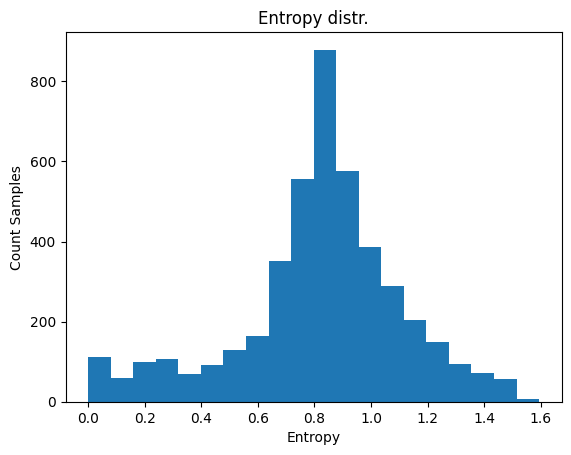

In [177]:
plt.hist(confusion_pairs["entropy"], bins= 20)
plt.title("Entropy distr.")
plt.xlabel("Entropy")
plt.ylabel("Count Samples")
plt.show()


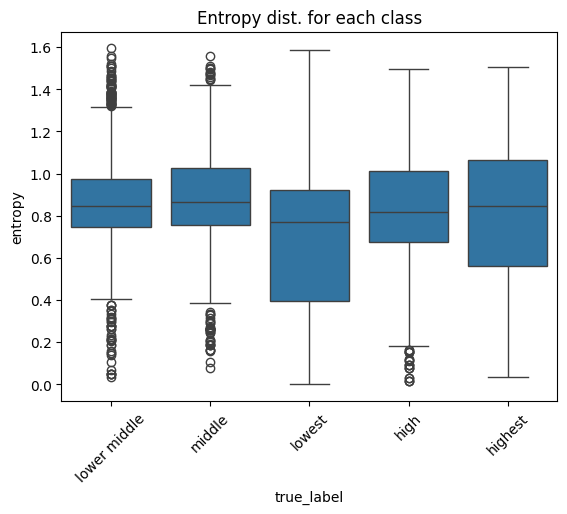

In [178]:
sns.boxplot(data=confusion_pairs, x="true_label", y="entropy")
plt.xticks(rotation=45)
plt.title("Entropy dist. for each class")
plt.show()


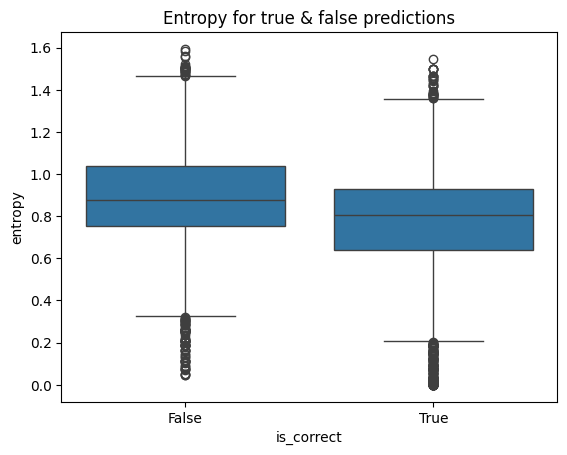

In [179]:
confusion_pairs["is_correct"] = confusion_pairs["true_label"] == confusion_pairs["predicted_top1"]

sns.boxplot(data=confusion_pairs, x="is_correct", y="entropy")
plt.title("Entropy for true & false predictions")
plt.show()


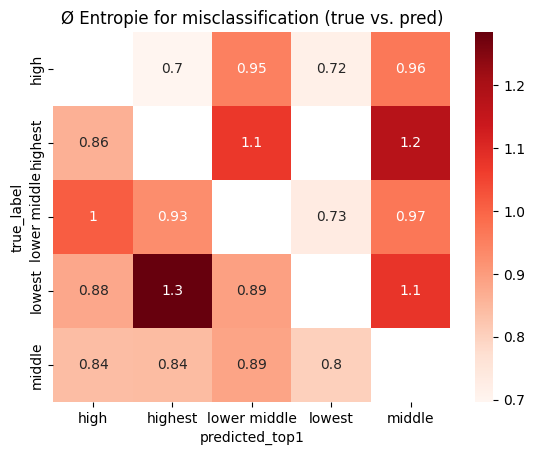

In [180]:
import numpy as np

error_only = confusion_pairs[~confusion_pairs["is_correct"]]
pivot_error_only = error_only.pivot_table(values="entropy", index="true_label", columns="predicted_top1", aggfunc="mean")

sns.heatmap(pivot_error_only, annot=True, cmap="Reds")
plt.title("Ø Entropie for misclassification (true vs. pred)")
plt.show()


# 3. MultinomialNB

## 3.1 Initial Model Pipeline

In [181]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import MultinomialNB

pipe_mnb = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ("nb", MultinomialNB())
])

## 3.2 Parameter Training

In [182]:

param_grid = {
    "nb__alpha": [1e-3, 1e-2, 0.05, 0.1, 0.3, 1.0, 3.0, 10.0]
}

gs_mnb = run_gridsearch(pipe=pipe_mnb, param_grid=param_grid, X=X_train, y=y_train, name="MultiNB")

MultiNB best params: {'nb__alpha': 0.001} | best f1: 0.4955


c:\Users\timmn\OneDrive\Dokumente\GitHub\Probabilistic-Machine-Learning_lecture-PROJECTS\projects\13-3NTXXXX_microcensus_income\venv\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [183]:
_ = calculate_cv(gs_mnb.best_estimator_, X_train, y_train["income"], cv, scoring)

accuracy: 0.5150 ± 0.0050
f1_macro: 0.4955 ± 0.0091
neg_log_loss: -1.2710 ± 0.0153


# 4. ComplementNB

## 4.1 Initial Model Pipeline

In [184]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import ComplementNB

pipe_compnb = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ("nb", ComplementNB())
])

## 4.2 Parameter Training

In [185]:

param_grid = {
    "nb__alpha": [1e-3, 1e-2, 0.05, 0.1, 0.3, 1.0, 3.0, 10.0]
}

gs_compnb = run_gridsearch(pipe=pipe_compnb, param_grid=param_grid, X=X_train, y=y_train, name="ComplNB")

ComplNB best params: {'nb__alpha': 0.1} | best f1: 0.4544


c:\Users\timmn\OneDrive\Dokumente\GitHub\Probabilistic-Machine-Learning_lecture-PROJECTS\projects\13-3NTXXXX_microcensus_income\venv\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [186]:
_ = calculate_cv(gs_compnb.best_estimator_, X_train, y_train["income"], cv, scoring)

accuracy: 0.4848 ± 0.0047
f1_macro: 0.4544 ± 0.0040
neg_log_loss: -1.3197 ± 0.0049
